# Identifying arXiv Article Subject Codes via NLP

The goal of this project is to predict primary subject codes for scientific articles available in the arXiv database based on the text of their abstract. This allows for rapid encoding of article subject material, and similar methods may be applicable for identifying key terms in articles submitted for addition to the database. 

Without machine learning, idexing articles for addition to a database along subject codes, key terms, and other metrics is a labor intensive process. For some databases, the labor cost of indexing a single article has been estimated to cost up to 10 dollars per article. Natural Language Processing offers the ability to automate this process, thereby saving up to 15 million dollars in labor for a dataset similar in size to the one used for this project upon intial upload. Maintenance costs may see further cost savings as routine updates to the database architecture or indexing system can be automated instead of requiring large quantities of expensive manual labor.

In [1]:
#imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

2023-02-01 01:00:46.463138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 01:00:47.215256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/lib:
2023-02-01 01:00:47.215354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so

In [2]:
#import data
df = pd.read_csv("./arxiv-oai-af.tsv", delimiter="\t")
df

,abstract,acm_class,arxiv_id,author_text,categories,comments,created,doi,num_authors,num_categories,primary_cat,title,updated
0,If we assume the Thesis that any classical T...,NaN,math/0212388,Bhupinder Singh Anand,math.GM,12 pages. Revision 1. Appendix 1 added. An HTM...,2002-12-31,NaN,1,1,math.GM,Is a deterministic universe logically consiste...,2003-01-02
1,"We define the Cartesian product, composition...",NaN,1205.6123,"Muhammad Akram, Wieslaw A. Dudek",cs.DM,NaN,2012-04-29,10.1016/j.camwa.2010.11.004,2,1,cs.DM,Interval-valued fuzzy graphs,NaN
2,We apply algebraic Morse theory to the Taylo...,NaN,1806.07887,Robin Frankhuizen,"math.AT,math.AC,math.RA",27 pages; comments welcome. arXiv admin note: ...,2018-06-20,NaN,1,3,math.AT,Massey products and the Golod property for sim...,NaN
3,Anomalous transport is usually described eit...,NaN,1007.3022,"Bartlomiej Dybiec, Ewa Gudowska-Nowak","cond-mat.stat-mech,math-ph,math.MP","10 pages, 7 figures",2010-07-18,10.1063/1.3522761,2,3,cond-mat.stat-mech,Subordinated diffusion and CTRW asymptotics,2010-11-09
4,"In this paper, an approximate solution to a ...",NaN,1512.07787,"M. T. Araujo, E. Drigo Filho",cond-mat.stat-mech,"12 pages, 8 figures",2015-12-24,10.5488/CMP.18.43003,2,1,cond-mat.stat-mech,Approximate solution for Fokker-Planck equation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582236,21cm intensity mapping experiments aim to ob...,NaN,1501.03823,"Laura Wolz, Filipe B. Abdalla, David Alonso, C...",astro-ph.CO,This article is part of the 'SKA Cosmology Cha...,2015-01-15,NaN,10,1,astro-ph.CO,Foreground Subtraction in Intensity Mapping wi...,NaN
1582237,We show the existence of smooth isolated cur...,NaN,math/0110220,Andreas Leopold Knutsen,math.AG,18 pages. The previous version of the preprint...,2001-10-19,NaN,1,1,math.AG,"Smooth, isolated curves in families of Calabi-...",2012-09-05
1582238,Sequence alignment is a tool in bioinformati...,NaN,0907.2187,"S Wolfsheimer, O Melchert, AK Hartmann","cond-mat.stat-mech,cond-mat.dis-nn,q-bio.QM",NaN,2009-07-13,10.1103/PhysRevE.80.061913,3,3,cond-mat.stat-mech,Finite-temperature local protein sequence alig...,NaN
1582239,"We suggest that the majority of the ""young"",...",NaN,astro-ph/0209553,Valery V. Kravtsov,astro-ph,"7 pages, no figures, accepted for publication ...",2002-09-26,10.1051/0004-6361:20021404,1,1,astro-ph,Second Parameter Globulars and Dwarf Spheroida...,NaN


In [3]:
#find explicit nulls
df.isnull().sum()

abstract                0
acm_class         1560822
arxiv_id                0
author_text             0
categories              0
comments           301829
created                 0
doi                734897
num_authors             0
num_categories          0
primary_cat             0
title                   0
updated            991881
dtype: int64

In [4]:
#drop unnecessary columns 
trimmed_df = df.drop(columns=["acm_class", 
                              "comments", 
                              "created", 
                              "num_authors", 
                              "num_categories", 
                              "updated", 
                              "doi", 
                              "categories", 
                              "author_text", 
                              "title"]
                    )
trimmed_df

,abstract,arxiv_id,primary_cat
0,If we assume the Thesis that any classical T...,math/0212388,math.GM
1,"We define the Cartesian product, composition...",1205.6123,cs.DM
2,We apply algebraic Morse theory to the Taylo...,1806.07887,math.AT
3,Anomalous transport is usually described eit...,1007.3022,cond-mat.stat-mech
4,"In this paper, an approximate solution to a ...",1512.07787,cond-mat.stat-mech
...,...,...,...
1582236,21cm intensity mapping experiments aim to ob...,1501.03823,astro-ph.CO
1582237,We show the existence of smooth isolated cur...,math/0110220,math.AG
1582238,Sequence alignment is a tool in bioinformati...,0907.2187,cond-mat.stat-mech
1582239,"We suggest that the majority of the ""young"",...",astro-ph/0209553,astro-ph


In [5]:
#check for duplicate articles
trimmed_df["arxiv_id"].value_counts()

math/0212388    1
1511.00435      1
1003.0352       1
1403.6630       1
1606.07245      1
               ..
0710.1146       1
1508.04795      1
0909.0182       1
1101.0001       1
1309.3564       1
Name: arxiv_id, Length: 1582241, dtype: int64

In [6]:
#full dataset turned out to be too large for training with available resources
#Need to create dataset with equal number of samples per category
pd.set_option('display.max_rows', 200)
trimmed_df["primary_cat"].value_counts()

hep-ph                107925
astro-ph               94239
hep-th                 86019
quant-ph               71567
cond-mat.mes-hall      46310
gr-qc                  45681
cond-mat.mtrl-sci      39348
cond-mat.str-el        35899
cond-mat.stat-mech     32370
astro-ph.SR            30147
astro-ph.CO            29493
math.AP                28783
math.CO                27755
nucl-th                27524
astro-ph.GA            27103
math.PR                26395
cs.CV                  25941
math-ph                25426
math.AG                25312
cond-mat.supr-con      25137
astro-ph.HE            24153
cs.IT                  23048
math.NT                20834
math.DG                20613
cond-mat.soft          19548
hep-ex                 18774
cs.LG                  18178
physics.optics         17130
hep-lat                15185
math.OC                14899
math.DS                14742
math.NA                13912
math.FA                12971
astro-ph.EP            12844
cond-mat      

In [7]:
#in order to train properly, we should have at least 1000 examples for each category in our dataset

#subset subjects that have more than 1000 examples in the original dataset
prim = trimmed_df["primary_cat"].value_counts()
print(f"total categories: {len(prim)}")
n_subjects = len([i for i in prim if i>1000])
print(f"number of subjects: {n_subjects}")
balance = prim[:n_subjects]
index = np.array(balance.index)

#drop low frequency subjects
subject = trimmed_df["primary_cat"]
balanced_df = trimmed_df[subject.isin(index)]
balanced_df.shape

total categories: 172
number of subjects: 129


(1560961, 3)

In [8]:
#randomly sample each category to contain 1000 samples from the overall dataset
#necessary for class balance and practical computation limits without GPU acceleration
#final dataset should contain 129,000 entries for train test splitting

rand_sam_df = balanced_df.groupby('primary_cat').apply(lambda s: s.sample(1000))
    
rand_sam_df

abstract  \
primary_cat                                                              
alg-geom    529817     We show that the Hodge numbers of the moduli...   
            1230101    This paper is concerned with determining the...   
            739948     Normal affine algebraic varieties in charact...   
            1044495    Let $M$ be a Kaehler manifold, and consider ...   
            1381120    Let $\M_{k}^{n}$ be the moduli space of base...   
...                                                                ...   
stat.ML     1037419    Consider the following class of learning sch...   
            1241511    Echo state networks are powerful recurrent n...   
            947354     When applied to training deep neural network...   
            1548635    General predictive models do not provide a m...   
            448504     We study critera for a pair $ (\{ X_n \} $, ...   

                             arxiv_id primary_cat  
primary_cat                                        
alg-geom    529817   alg-geom/9408001    alg-geom  
            1230101  alg-geom/9703035    alg-geom  
            739948   alg-geom/9703014    alg-geom  
            1044495  alg-geom/9710026    alg-geom  
            1381120  alg-geom/9610008    alg-geom  
...                               ...         ...  
stat.ML     1037419        1807.02694     stat.ML  
            1241511        1802.07369     stat.ML  
            947354         1709.01427     stat.ML  
            1548635        1609.05959     stat.ML  
            448504         1804.10821     stat.ML  

[129000 rows x 3 columns]

In [9]:
#category sanity check
rand_sam_df["primary_cat"].value_counts()

alg-geom              1000
math.CT               1000
physics.acc-ph        1000
nucl-th               1000
nucl-ex               1000
nlin.SI               1000
nlin.PS               1000
nlin.CD               1000
nlin.AO               1000
math.ST               1000
math.SP               1000
math.SG               1000
math.RT               1000
math.RA               1000
math.QA               1000
math.PR               1000
math.OC               1000
math.OA               1000
math.NT               1000
math.NA               1000
math.MG               1000
math.LO               1000
math.KT               1000
math.HO               1000
math.GT               1000
math.GR               1000
math.GN               1000
math.GM               1000
math.FA               1000
math.DS               1000
math.DG               1000
physics.ao-ph         1000
physics.app-ph        1000
physics.atom-ph       1000
physics.space-ph      1000
stat.ME               1000
stat.CO               1000
s

In [10]:
#save data file in csv for reproducibility
rand_sam_df.to_csv("./extended_project_subset_data")

In [11]:
#importing data and assigning key variables for training
rand_sam_df = pd.read_csv("./extended_project_subset_data")

#hard coding n_subjects determined programmatically above
#note: this is being done for reproducibility, as the random 
#sampling performed above cannot be replicated exactly in the future
n_subjects = 129

In [12]:
#train test split
train, test = train_test_split(rand_sam_df, test_size=0.2, random_state=42)

# Iterative Modeling

In [13]:
#target encoder
def encode_target(data, features=n_subjects, input_type="string"):
    """takes a set of y values and one hot encodes them for the Neural Network output"""
    FH = FeatureHasher(n_features=features, input_type=input_type)
    target = FH.fit_transform(X=data)
    target_array = target.toarray()
    return target_array

#one hot encoding target for training set
train_target = encode_target(train["primary_cat"])

In [14]:
#creating encoder to clean and encode abstract data
encoder = layers.experimental.preprocessing.TextVectorization(output_mode='int')
#calling adapt gets the layer to index all of the terms
#this step speeds up model performance and reduces parameters
encoder.adapt(np.array(train["abstract"]))

2023-02-01 01:01:20.777433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-01 01:01:20.777488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-34-239.us-east-2.compute.internal): /proc/driver/nvidia/version does not exist
2023-02-01 01:01:20.778279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Testing Scalability - RNN model should be able to scale performance to more categories easier than other modeling techniques. Below is a retraining of the final model from my original capstone work on the new dataset with 129 categories instead of the original 10.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 24)          6377304   
                                                                 
 batch_normalization (BatchN  (None, None, 24)         96        
 ormalization)                                                   
                                                                 
 gru (GRU)                   (None, 18)                2376      
                                                                 
 dense (Dense)               (None, 12)                228       
                                                                 
 dense_1 (Dense)             (None, 12)                1

/home/ec2-user/anaconda3/envs/capstone/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


2580/2580 [==============================] - 278s 106ms/step - loss: 0.8620 - accuracy: 0.1913 - auc: 0.6074 - categorical_crossentropy: -47.3554 - val_loss: 0.8477 - val_accuracy: 0.2421 - val_auc: 0.6174 - val_categorical_crossentropy: -54.5497
Epoch 2/50
2580/2580 [==============================] - 272s 106ms/step - loss: 0.8495 - accuracy: 0.1953 - auc: 0.6166 - categorical_crossentropy: -57.1049 - val_loss: 0.8470 - val_accuracy: 0.2421 - val_auc: 0.6180 - val_categorical_crossentropy: -58.7759
Epoch 3/50
2580/2580 [==============================] - 274s 106ms/step - loss: 0.8421 - accuracy: 0.1966 - auc: 0.6169 - categorical_crossentropy: -59.2381 - val_loss: 0.8099 - val_accuracy: 0.2666 - val_auc: 0.6184 - val_categorical_crossentropy: -59.9675
Epoch 4/50
2580/2580 [==============================] - 273s 106ms/step - loss: 0.8057 - accuracy: 0.1818 - auc: 0.6168 - categorical_crossentropy: -62.3852 - val_loss: 0.7975 - val_accuracy: 0.1309 - val_auc: 0.6171 - val_categorical_cr

Epoch 33/50
2580/2580 [==============================] - 281s 109ms/step - loss: 0.5253 - accuracy: 0.2675 - auc: 0.5634 - categorical_crossentropy: -72.1446 - val_loss: 0.6056 - val_accuracy: 0.2437 - val_auc: 0.5662 - val_categorical_crossentropy: -72.0304
Epoch 34/50
2580/2580 [==============================] - 280s 109ms/step - loss: 0.5250 - accuracy: 0.2684 - auc: 0.5634 - categorical_crossentropy: -72.3018 - val_loss: 0.6105 - val_accuracy: 0.2459 - val_auc: 0.5630 - val_categorical_crossentropy: -72.2981
Epoch 35/50
2580/2580 [==============================] - 280s 109ms/step - loss: 0.5247 - accuracy: 0.2685 - auc: 0.5634 - categorical_crossentropy: -72.4577 - val_loss: 0.6069 - val_accuracy: 0.2518 - val_auc: 0.5651 - val_categorical_crossentropy: -72.3581
Epoch 36/50
2580/2580 [==============================] - 280s 109ms/step - loss: 0.5246 - accuracy: 0.2686 - auc: 0.5634 - categorical_crossentropy: -72.6032 - val_loss: 0.6087 - val_accuracy: 0.2589 - val_auc: 0.5648 - val

INFO:tensorflow:Assets written to: ./scale_test_model/assets


INFO:tensorflow:Assets written to: ./scale_test_model/assets


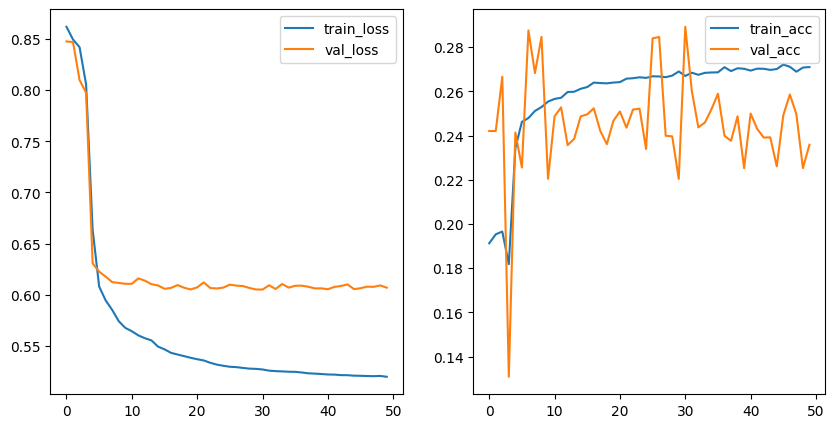

In [15]:
#scaling test model
model7 = Sequential([
    #input layer
    tf.keras.Input(shape=(1,), dtype=tf.string),
    #encoder from cell above
    encoder,
    #embedding layer
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary())+1,
        output_dim=24,
        # Use masking to handle the variable abstract lengths
        mask_zero=True),
    #batch normalization
    tf.keras.layers.BatchNormalization(),
    #recurrent layer
    tf.keras.layers.GRU(18),
    #decision time
    tf.keras.layers.Dense(12, activation='tanh'),
    tf.keras.layers.Dense(12, activation='tanh'),
    tf.keras.layers.Dense(12, activation='tanh'),
    tf.keras.layers.Dense(n_subjects, activation='softmax')
])

#compiling the model
model7.compile(
    loss='categorical_hinge',
    #steeper clipping
    optimizer=tf.keras.optimizers.Adam(amsgrad=True, clipnorm=1.0),
    metrics=['accuracy', 
             'AUC', 
             tf.keras.metrics.CategoricalCrossentropy()]
)

#fit the model
print(model7.summary())
NL7 = model7.fit(x=train["abstract"], y=train_target, epochs=50,
                     batch_size=32, validation_split=0.2)

#save the 7th model
model7.save("./scale_test_model")

#training charts for model 7 (highest accuracy)
train_loss = NL7.history['loss']
train_acc = NL7.history['accuracy']
val_loss = NL7.history['val_loss']
val_acc = NL7.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=NL7.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=NL7.epoch, y=train_acc, ax=ax2, label='train_acc')

sns.lineplot(x=NL7.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=NL7.epoch, y=val_acc, ax=ax2, label='val_acc');

# New Modeling 

In [ ]:
#1st model
model = Sequential([
    #input layer
    tf.keras.Input(shape=(1,), dtype=tf.string),
    #encoder from cell above
    encoder,
    #embedding layer
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary())+1,
        output_dim=256,
        # Use masking to handle the variable abstract lengths
        mask_zero=True),
    #wide recurrent layer
    tf.keras.layers.GRU(256),
    #decision time
    tf.keras.layers.Dense(n_subjects, activation='tanh'),
    tf.keras.layers.Dense(n_subjects, activation='softmax')
])

#compiling the model
model7.compile(
    loss=tf.keras.metrics.CategoricalCrossentropy(),
    #steeper clipping
    optimizer=tf.keras.optimizers.Adam(amsgrad=True, clipnorm=1.0),
    metrics=['accuracy', 
             'AUC']
)

#fit the model
print(model.summary())
NL = model.fit(x=train["abstract"], y=train_target, epochs=50,
                     batch_size=32, validation_split=0.2)

#save the model
model.save("./extended_init_model")

#training charts for model
train_loss = NL.history['loss']
train_acc = NL.history['accuracy']
val_loss = NL.history['val_loss']
val_acc = NL.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=NL.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=NL.epoch, y=train_acc, ax=ax2, label='train_acc')

sns.lineplot(x=NL.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=NL.epoch, y=val_acc, ax=ax2, label='val_acc');